# Toy 1D Regression Examples

We consider 4 one-dimensional toy regression problems where the latent function and, consequently, the highest performance achievable, are known.

We show that the data valuation analysis of the `kxy` package is able to recover the true highest achievable performances (e.g. $R^2$, RMSE, etc.) almost perfectly.

In [1]:
%load_ext autoreload
%autoreload 2

import pylab as plt
import pandas as pd
import numpy as np
np.random.seed(0)
import kxy

## The Data
We use generative models of the form $$y=f_i(x)+\epsilon, ~~ \text{with} ~~ \text{Var}\left(f_i(x)\right)=1.$$

We use the functional forms $$f_1(x) \propto x, ~~~~ f_2(x) \propto \sqrt{\left\vert x \right\vert}, ~~~~ f_3(x) \propto -x^3, ~~ \text{and} ~~ f_4(x) \propto \tanh \left(\frac{5}{2} x \right)$$
with $x \sim U\left([-1, 1] \right)$ uniformly distributed, and $\epsilon$ a Gaussian noise.

### Background
The classic definitions of the $R^2$ and the RMSE of a regression model $y = f\left(x\right) + \epsilon$ are respectively $$R^2\left(f\right) := 1-\frac{\text{Var}(\epsilon)}{\text{Var}(y)} = 1-\frac{\text{Var}(y \vert x)}{\text{Var}(y)}$$ and $$\text{RMSE}\left(f\right) := \text{Var}( \epsilon) = \text{Var}(y \vert x).$$

These definitions are OK when $y$ and $\epsilon$ are Gaussian, but the variance terms fail to fully capture uncertainty in non-Gaussian distribution (e.g. fat-tails). 

Note that, when $y$ and $\epsilon$ are Gaussian, we also have $R^2\left(f\right) = 1- e^{-2I\left(y;  f(x) \right)}$ and $\text{RMSE}\left(f\right) := \text{Var}(y) e^{-2I\left(y;  f(x) \right)}.$

Given that entropies are better measures of uncertainty than the variance, we can use these formulae to define generalized versions of the $R^2$ and the RMSE. 

The theoretical best values these generalized versions may take (across all possible models) are then found to be $\bar{R}^2 = 1- e^{-2I\left(y; x\right)}$ and $\bar{RMSE} = \text{Var}(y) e^{-2I\left(y; x \right)}.$


### Ground Truth Calculation
In this notebook, we choose various functional form for $f_i$ and we choose a Gaussian residual $\epsilon$. As such, we know the theoretical best values the classic $R^2$ and RMSE may take. 

However, we cannot calculate the true mutual information in closed form for all $f_i$ but $f_1$. Instead, we use as proxy for the best generalized $R^2$ and RMSE achievable (for $i>1$) the best classic $R^2$ and RMSE achievable.

This means that any deviation between our estimated highest generalized $R^2$ (resp. lowest generalized RMSE) and the true highest classic $R^2$  (resp. lowest classic RMSE) is a mix of estimation error and the fact that $f_i(x)$ is non-Gaussian for $i>1$.


### Noise Variance
We consider various highest achievable classic $R^2$ values ($1., 0.99, 0.5, 0.25$) and we infer the corresponding noise variance as $\sigma^2 = \frac{1}{R^2}-1 = \text{RMSE}^2$.

In [2]:
# Sample size
n = 2000 
x = np.arange(-1., 1.01, 1./(2*n))

# Noiseless functions
names = [r'''$y=x$''', r'''$y=\sqrt{|x|}$''', r'''$y=-x^3$''', r'''$y=\tanh\left(\frac{5}{2}x\right)$''']
fs = [lambda u: u, lambda u: -np.sqrt(np.abs(u)), lambda u: (-u)**3, lambda u: np.tanh(2.5*u)]

# Noise configurations
rsqs = np.array([1., .99, .75, .50, .25]) # Desired  Exact R^2
err_var = 1./rsqs-1.
err_std = np.sqrt(err_var) # Implied Exact RMSE assuming 

# Generate the data
data = [[]]*len(rsqs)
for i in range(len(rsqs)):
    dfl = []
    for j in range(len(fs)):
        y_ = fs[j](x)
        y = y_/y_.std()
        y = y + err_std[i]*np.random.randn(x.shape[0])
        z = np.concatenate([y[:, None], x[:, None]], axis=1)
        df = pd.DataFrame(z.copy(), columns=['y', 'x'])
        dfl += [df.copy()]
        
    data[i] = dfl

## Data Valuation

In [3]:
estimated_rsqs = [[None for j in range(len(fs))] for i in range(len(rsqs))]
estimated_rmses = [[None for j in range(len(fs))] for i in range(len(rsqs))]

for i in range(len(rsqs)):
    print('\n\n')
    print(r'''-------------------------------------''')
    print(r'''Exact $R^2$: %.2f, Exact RMSE: %.2f''' % (rsqs[i], err_std[i]))
    print(r'''-------------------------------------''')
    for j in range(len(fs)):
        print()
        print('KxY estimation for %s' % names[j])
        dv = data[i][j].kxy.data_valuation('y', problem_type='regression')
        estimated_rsqs[i][j] = float(dv['Achievable R-Squared'][0])
        estimated_rmses[i][j] = float(dv['Achievable RMSE'][0])
        print(dv)




-------------------------------------
Exact $R^2$: 1.00, Exact RMSE: 0.00
-------------------------------------

KxY estimation for $y=x$
[====================================================================================================] 100% ETA: 0s   
  Achievable R-Squared Achievable Log-Likelihood Per Sample Achievable RMSE
0                 1.00                                 5.08        1.61e-03

KxY estimation for $y=\sqrt{|x|}$
[====================================================================================================] 100% ETA: 0s   
  Achievable R-Squared Achievable Log-Likelihood Per Sample Achievable RMSE
0                 1.00                                 3.56        7.43e-03

KxY estimation for $y=-x^3$
[====================================================================================================] 100% ETA: 0s   
  Achievable R-Squared Achievable Log-Likelihood Per Sample Achievable RMSE
0                 1.00                                 3.9

## Visualizing $R^2$ Estimation

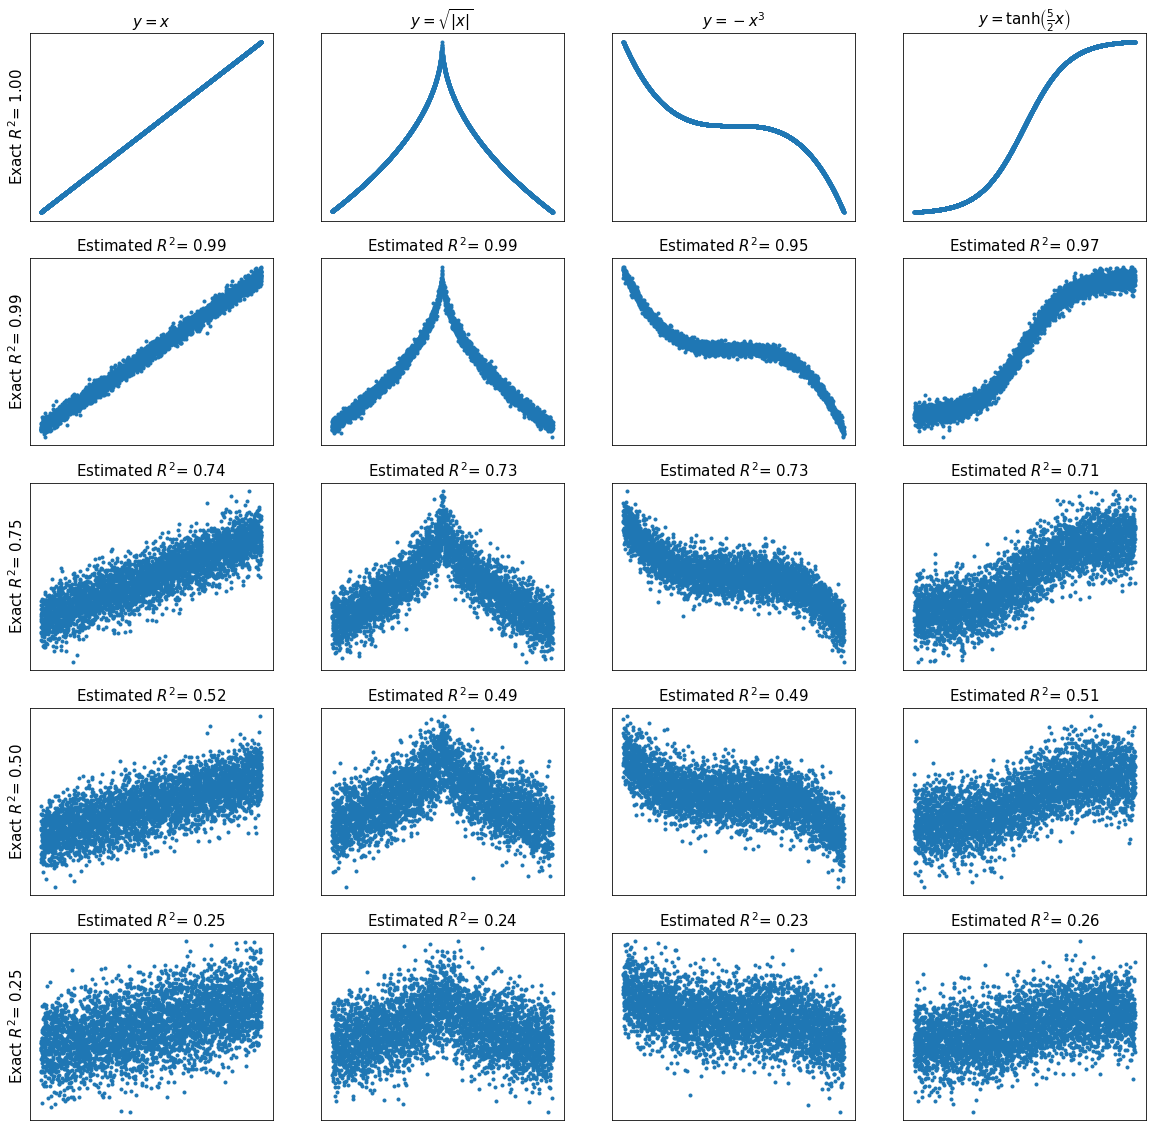

In [4]:
fig, axes = plt.subplots(len(rsqs), len(fs), figsize=(20, 20))
for i in range(len(rsqs)):
    for j in range(len(fs)):
        df = data[i][j].copy()
        y = df['y'].values
        axes[i, j].plot(x, y, '.')
        axes[i, j].set_xticks(())
        axes[i, j].set_yticks(())
        if i == 0:
            axes[i, j].set_title(names[j], fontsize=15)
        else:
            axes[i, j].set_title(r'''Estimated $R^2$= %.2f''' % estimated_rsqs[i][j], fontsize=15)         
        if j == 0:
            axes[i, j].set_ylabel(r'''Exact $R^2$= %.2f''' % rsqs[i], fontsize=15)

## Visualizing RMSE Estimation

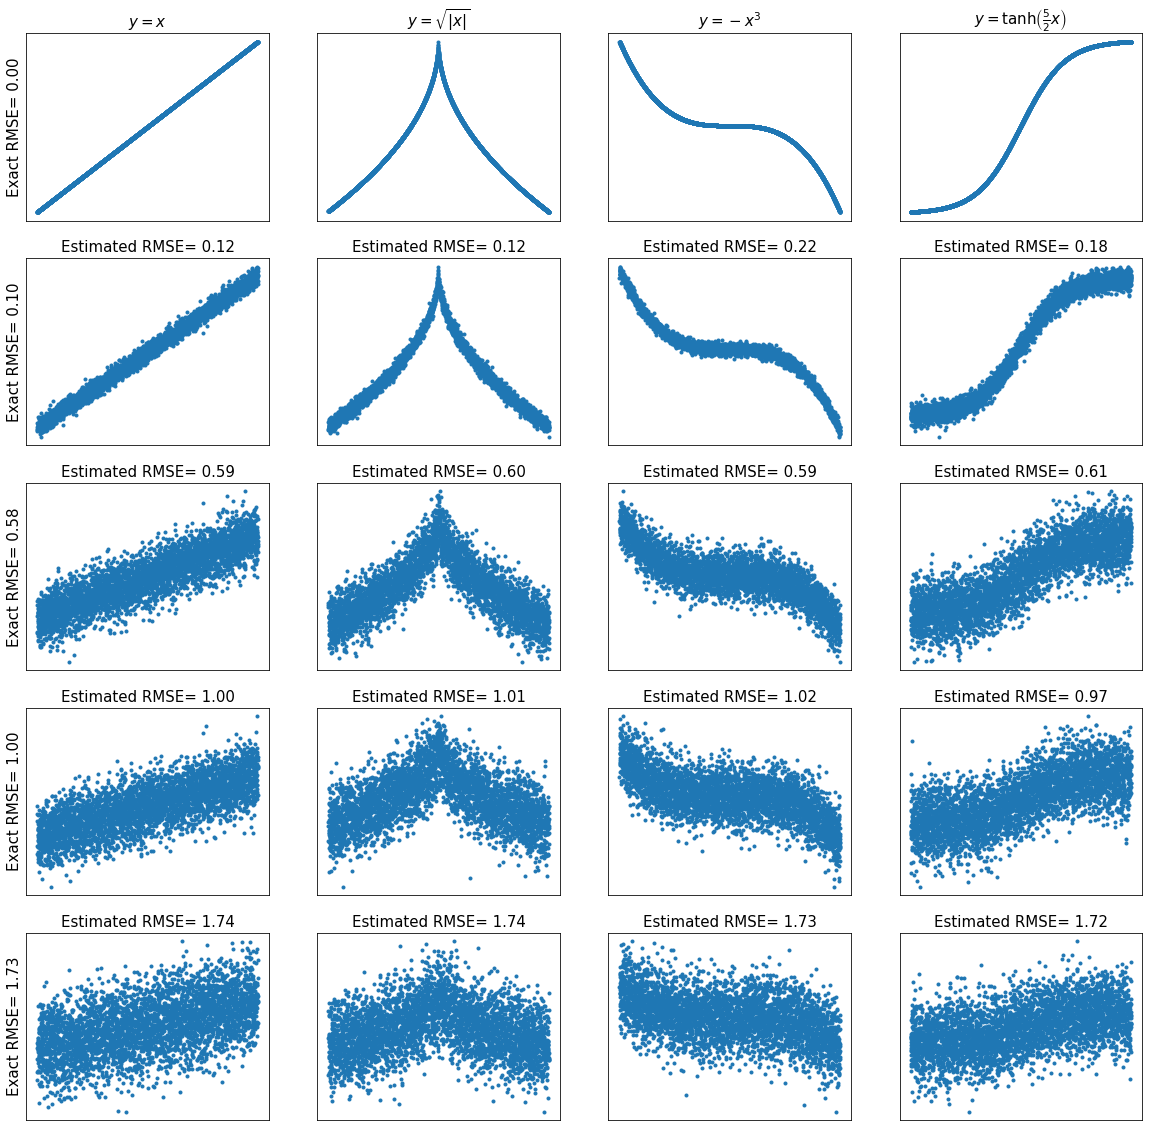

In [5]:
fig, axes = plt.subplots(len(rsqs), len(fs), figsize=(20, 20))
for i in range(len(rsqs)):
    for j in range(len(fs)):
        df = data[i][j].copy()
        y = df['y'].values
        axes[i, j].plot(x, y, '.')
        axes[i, j].set_xticks(())
        axes[i, j].set_yticks(())
        if i == 0:
            axes[i, j].set_title(names[j], fontsize=15)
        else:
            axes[i, j].set_title(r'''Estimated RMSE= %.2f''' % estimated_rmses[i][j], fontsize=15)         
        if j == 0:
            axes[i, j].set_ylabel(r'''Exact RMSE= %.2f''' % err_std[i], fontsize=15)